In [1]:
%run /data/NNDSP/anal/analysis_notebooks/util.ipynb

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Setup

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [7]:
analysis_version = "2018_08_14"
project_dir = Path('/gpfs/gsfs6/users/NNDSP')

# Bids Directory
nndsp_bar = project_dir.joinpath('derivatives/bar_nndsp') # baracus bids

# Brain Age File
nndsp_pheno = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

# NNDSP Data

In [25]:
nndsp_subj = [p.as_posix() for p in nndsp_bar.glob('sub-*')] # search all subj in baracus directory
df_nndsp = pd.DataFrame(nndsp_subj, columns = ['subj_path']) # turn the subjects into df
df_nndsp = df_nndsp.assign(participant = lambda df: df.subj_path.str.extract('sub-(\d{2,4})', expand=True))
#add participant number column

In [26]:
# Getting Age
df_nndsp_target = pd.read_csv(nndsp_pheno, sep=',') # open file with ages

In [27]:
df_nndsp = df_nndsp.assign(MASKID = lambda df: pd.DataFrame([int(x) for x in df.participant]))
df_nndsp = df_nndsp.merge(df_nndsp_target, on='MASKID') # merge age predictions with actual age
df_nndsp = df_nndsp.rename(columns={'MASKID': 'subject', 'Sex': 'sex', 'age_at_scan' : 'age'})

In [28]:
df_nndsp.head()

,subj_path,participant,subject,MRN,nuclear_fam_id,sex,age
0,/gpfs/gsfs6/users/NNDSP/derivatives/bar_nndsp/...,1889,1889,7135075,10230,Female,9.667351
1,/gpfs/gsfs6/users/NNDSP/derivatives/bar_nndsp/...,2011,2011,7078997,10109,Male,18.310746
2,/gpfs/gsfs6/users/NNDSP/derivatives/bar_nndsp/...,1948,1948,4571265,1854,Female,14.269678
3,/gpfs/gsfs6/users/NNDSP/derivatives/bar_nndsp/...,1198,1198,4359628,1613,Male,14.390144
4,/gpfs/gsfs6/users/NNDSP/derivatives/bar_nndsp/...,1371,1371,7218874,10286,Male,16.621492


## Train Complex Model on NNDSP Data

In [31]:
# Bids Directory
nndsp_fs = project_dir.joinpath('derivatives/fs5.3_nndsp') # freesurfer bids

### Load Subjects

In [32]:
import os
from glob import glob

# get the subjects in the freesurfer directory
nndsp_subj = [os.path.basename(s) for s in sorted(glob(os.path.join(nndsp_fs, "sub-*")))]

### Extract Freesurfer Data

In [34]:
subjects_to_analyze = subject_to_anal(nndsp_subj, nndsp_bar)
features = extract_features(subjects_to_analyze, nndsp_bar)

In [44]:
# get subjects with good MRPAGE raiting relevant subjects
nndsp_qcscans = pd.read_csv('/data/NNDSP/derivatives/mriqc_2018_06_08/manual_qc_round_2.tsv', sep='\t')
nndsp_qcscans = nndsp_qcscans[nndsp_qcscans.MPRAGE <= 2.0][nndsp_qcscans.Freesurfer_avg_ext_rating <= 2.0]
nndsp_qcscans.shape

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(324, 15)

In [45]:
# find subjects that have both good and bad scans, as these get put together in freesurfer output
nndsp_bad_qc = pd.read_csv('/data/NNDSP/derivatives/mriqc_2018_06_08/manual_qc_round_2.tsv', sep='\t')
nndsp_bad_qc = nndsp_bad_qc[nndsp_bad_qc.MPRAGE > 2.0]
for subject in nndsp_bad_qc.MASKID:
    if subject in nndsp_qcscans.MASKID.values:
        nndsp_qcscans = nndsp_qcscans[nndsp_qcscans.MASKID != subject]

In [46]:
# drop duplicate subjects
nndsp_qcscans = nndsp_qcscans.drop_duplicates(subset='MASKID', keep='first')
nndsp_qcscans = nndsp_qcscans.rename(columns = {'MASKID':'subject'})
nndsp_qcscans.shape

(324, 15)

In [47]:
# merge the subjects that have good overall scans with df_nndsp
df_nndsp = pd.merge(df_nndsp, nndsp_qcscans[['subject']], on='subject')
print(len(df_nndsp))

319


In [48]:
df_target = df_nndsp[['subject', 'age']]
len(df_target)

319

### Complex Model

#### Cortical Thickness

In [49]:
nndsp_ct = get_source_data('thickness', features, df_target, on='subject') # extract thickness info from features
nndsp_ct = nndsp_ct.sort_values(by='subject')
nndsp_ct.head()

,0,1,2,3,4,5,6,7,8,9,...,5116,5117,5118,5119,5120,5121,5122,5123,subject,age
0,3.305366,3.226945,2.209841,3.212811,2.919251,2.354458,2.736327,0.000000,3.154292,2.768955,...,4.274560,3.358513,3.722817,4.288706,3.870009,3.912924,3.638119,2.891106,102,28.542094
1,2.900267,2.444894,2.336694,3.010283,3.012766,3.304097,1.675746,0.066457,2.338948,3.014964,...,2.928249,3.701230,2.258687,3.005228,2.441895,2.660963,3.203947,3.047076,126,6.015058
2,3.167699,3.679227,1.833072,3.248728,3.608622,3.156340,2.562178,1.326940,3.019244,2.868043,...,3.292794,2.677688,3.738858,2.626664,2.300391,2.418707,2.721444,2.479909,127,7.926078
3,3.277886,3.069667,2.171888,2.266851,2.950705,3.218155,2.977520,0.084246,2.545784,2.316982,...,3.501819,4.138763,4.044869,3.091959,3.834360,3.635386,3.209997,3.114844,133,22.168378
4,2.882014,2.434137,2.497086,3.072949,2.784366,2.344710,1.847144,1.020120,2.674035,2.682842,...,3.877345,4.306041,3.599642,3.120880,2.354324,3.843007,2.810621,3.360790,142,22.316222


In [50]:
#split test and train data into equal parts
X_train_ct, X_test_ct, y_train_ct, y_test_ct, nndsp_pipe_ct = train_test_pipeline(nndsp_ct.iloc[:, :5124], 
                                                                            nndsp_ct.age, 
                                                                            test_size = 0.5, random_state=None)
# fit model
nndsp_pipe_ct.fit(X=X_train_ct, y=y_train_ct)

Pipeline(memory=None,
     steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [51]:
# prediction and errors
y_predicted_train_ct = nndsp_pipe_ct.predict(X_train_ct)
y_predicted_test_ct = nndsp_pipe_ct.predict(X_test_ct)

In [52]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ct, y_predicted_train_ct))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_ct, y_predicted_test_ct))

Mean Absolute Error (Train): 0.0985480743217671
Mean Absolute Error (Test): 5.780385930797431


In [53]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction 
y_predicted_ct_cv = cross_val_predict(nndsp_pipe_ct, X_train_ct, y_train_ct)

#### Subcortical Volumes

In [54]:
nndsp_sv = get_source_data('aseg', features, df_target, on='subject')
nndsp_sv = nndsp_sv.sort_values(by='subject')

In [55]:
# Train Test Split
X_train_sv, X_test_sv, y_train_sv, y_test_sv, nndsp_pipe_sv = train_test_pipeline(nndsp_sv.iloc[:, :66], 
                                                                            nndsp_sv.age, 
                                                                            test_size = 0.5, 
                                                                            random_state=None, model='yes', 
                                                                            model_train=X_train_ct, 
                                                                            model_test=X_test_ct)

# fit model
nndsp_pipe_sv.fit(X=X_train_sv, y= y_train_sv.as_matrix().ravel())

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


Pipeline(memory=None,
     steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [56]:
# prediction and errors
y_predicted_train_sv = nndsp_pipe_sv.predict(X_train_sv)
y_predicted_test_sv = nndsp_pipe_sv.predict(X_test_sv)

In [57]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_sv, y_predicted_train_sv))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_sv, y_predicted_test_sv))

Mean Absolute Error (Train): 3.608045490740048
Mean Absolute Error (Test): 5.9941279514864


In [58]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction
y_predicted_sv_cv = cross_val_predict(nndsp_pipe_sv, X_train_sv, y_train_sv.as_matrix().ravel())

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Cortical Surface Area

In [59]:
nndsp_ca = get_source_data('area', features, df_target, on='subject')
nndsp_ca = nndsp_ca.sort_values(by='subject')

In [60]:
# Train Test Split

#split test and train data into equal parts
X_train_ca, X_test_ca, y_train_ca, y_test_ca, nndsp_pipe_ca = train_test_pipeline(nndsp_ca.iloc[:, :5124], 
                                                                                  nndsp_ca.age, 
                                                                                  test_size = 0.5, 
                                                                                  random_state=None, 
                                                                                  model='yes', 
                                                                                  model_train=X_train_ct, 
                                                                                  model_test=X_test_ct)

# fit model
nndsp_pipe_ca.fit(X=X_train_ca, y=y_train_ca.as_matrix().ravel())

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


Pipeline(memory=None,
     steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [61]:
# prediction and errors
y_predicted_train_ca = nndsp_pipe_ca.predict(X_train_ca)
y_predicted_test_ca = nndsp_pipe_ca.predict(X_test_ca)

In [62]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ca, y_predicted_train_ca))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_ca, y_predicted_test_ca))

Mean Absolute Error (Train): 0.09962744753794227
Mean Absolute Error (Test): 8.001291900044373


In [63]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction
y_predicted_ca_cv = cross_val_predict(nndsp_pipe_ca, X_train_ca, y_train_ca.as_matrix().ravel())
print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ca, y_predicted_ca_cv))

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Mean Absolute Error (Train): 8.119911206532958


#### Stacked Anatomy

In [64]:
# stack predicted values
# get stacked age predictions (test and train) for ct
df_y_ct = get_stacked_ages(y_train_ct, y_predicted_train_ct, y_predicted_ct_cv, y_test_ct, y_predicted_test_ct, first=True)
# get stacked age prediction (test and train) for ca
df_y_ca = get_stacked_ages(y_train_ca, y_predicted_train_ca, y_predicted_ca_cv, y_test_ca, y_predicted_test_ca)
# get stacked age prediction (test and train) for sv
df_y_sv = get_stacked_ages(y_train_sv, y_predicted_train_sv, y_predicted_sv_cv, y_test_sv, y_predicted_test_sv)

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [65]:
# stacking function inputes
target = 'age'
source_dict = {'aseg': df_y_sv, 'ct': df_y_ct,'ca': df_y_ca}
source_selection_dict = {'fs': ['aseg', 'ct', 'ca'],}

In [66]:
scores_test, dd_train, dd_test, pipe_stack = stacking(source_dict, source_selection_dict, target, show=False)

Fitting stacking model
best max_depth: 3


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:112: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:113: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/data/migineishvilin2/python/en

In [67]:
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error (Train):", mean_absolute_error(dd_train.age_at_scan, dd_train.pred_age_train))
print("Mean Absolute Error (Test):", mean_absolute_error(dd_test.age_at_scan, dd_test.pred_age_test))
scores_test

Mean Absolute Error (Train): 3.7993787760326256
Mean Absolute Error (Test): 4.904538677546053


,r2,rpear,rpear2,mae,medae
aseg,0.715651,0.849884,0.722302,5.994128,4.606928
ct,0.734281,0.857089,0.734602,5.780386,5.045364
ca,0.465486,0.687657,0.472872,8.001292,6.187047
mean_pred,0.747384,0.879389,0.773324,5.376039,4.126535
pred_age_test,0.755379,0.873572,0.763129,4.904539,3.231094


In [68]:
y_predicted_stack_cv = cross_val_predict(pipe_stack, dd_train.iloc[:,:3], dd_train.age_at_scan.values)
print("Mean Absolute Error (Train):", mean_absolute_error(dd_train.age_at_scan.values, y_predicted_stack_cv))

Mean Absolute Error (Train): 5.712371268204721


### Simple Model

In [69]:
nndsp_atf = pd.DataFrame([])
nndsp_atf = nndsp_atf.assign(subs = [x for x in subjects_to_analyze])
nndsp_atf = nndsp_atf.assign(MASKID = [int(x[4:]) for x in subjects_to_analyze])
nndsp_atf = nndsp_atf.rename(columns={'MASKID' : 'subject'})
nndsp_atf = nndsp_atf.merge(df_target, on = 'subject')

In [70]:
white_matter, grey_matter, csf, intra_cran_vol = get_anat_features(nndsp_atf.subs.values, nndsp_bar)

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


In [71]:
nndsp_atf = nndsp_atf.assign(Intra_Cran_Vol = intra_cran_vol)
nndsp_atf = nndsp_atf.assign(WM_Frac = calc_fraction(white_matter, intra_cran_vol))
nndsp_atf = nndsp_atf.assign(GM_Frac = calc_fraction(grey_matter, intra_cran_vol))
nndsp_atf = nndsp_atf.assign(CSF_Frac = calc_fraction(csf, intra_cran_vol))
nndsp_atf = nndsp_atf.sort_values(by='subject')

In [72]:
X_train_atf, X_test_atf, y_train_atf, y_test_atf, nndsp_pipe_atf =  train_test_pipeline(nndsp_atf.iloc[:, 3:], 
                                                                                  nndsp_atf.age, 
                                                                                  test_size = 0.5, 
                                                                                  random_state=None, 
                                                                                  model='yes', 
                                                                                  model_train=X_train_ct, 
                                                                                  model_test=X_test_ct)
nndsp_pipe_atf.fit(X=X_train_atf, y=y_train_atf.as_matrix().ravel())

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Pipeline(memory=None,
     steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [73]:
# prediction and errors
y_predicted_train_atf = nndsp_pipe_atf.predict(X_train_atf)
y_predicted_test_atf = nndsp_pipe_atf.predict(X_test_atf)

In [74]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_atf, y_predicted_train_atf))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_atf, y_predicted_test_atf))

Mean Absolute Error (Train): 6.8049615091872155
Mean Absolute Error (Test): 6.968435724709093


In [75]:
from sklearn.cross_validation import cross_val_predict

y_predicted_atf_cv = cross_val_predict(nndsp_pipe_atf, X_train_atf, y_train_atf.as_matrix().ravel())
print("Mean Absolute Error (CV):", mean_absolute_error(y_train_atf, y_predicted_atf_cv))

Mean Absolute Error (CV): 7.229620343811139


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


# HCP Data

In [77]:
# HCP Directory
hcp_dir = Path('/data/HCP/HCP_1200/')
# HCP Outfir of Prepared Freesurfer Files
hcp_bar = project_dir.joinpath('derivatives/bar_hcp/')
# HCP Freesurfer Data
hcp_fs_dir = project_dir.joinpath('derivatives/fs_hcp/')

In [78]:
import matplotlib.pyplot as plt
df_hcp = pd.read_csv(project_dir.joinpath('nino/HCP_ages.csv'))
df_hcp = df_hcp.rename(columns={'Subject':'subject', 'Age_in_Yrs': 'age'})

In [79]:
hcp_subjs = [os.path.basename(s) for s in sorted(glob(os.path.join(hcp_bar, "sub-*")))]

In [81]:
# get age and subject number
hcp_atf = pd.DataFrame([])
hcp_atf = hcp_atf.assign(subject = [int(x[4:]) for x in subject_to_anal(hcp_subjs, hcp_bar)])
hcp_atf = hcp_atf.merge(df_hcp, on = 'subject')

In [82]:
white_matter, grey_matter, csf,intra_cran_vol = get_anat_features(subject_to_anal(hcp_subjs, hcp_bar), hcp_bar)

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


In [83]:
hcp_atf = hcp_atf.assign(Intra_Cran_Vol = intra_cran_vol)
hcp_atf = hcp_atf.assign(WM_Frac = calc_fraction(white_matter, intra_cran_vol))
hcp_atf = hcp_atf.assign(GM_Frac = calc_fraction(grey_matter, intra_cran_vol))
hcp_atf = hcp_atf.assign(CSF_Frac = calc_fraction(csf, intra_cran_vol))

In [84]:
hcp_features = extract_features(subject_to_anal(hcp_subjs, hcp_bar), hcp_bar)

## Test Against Complex Model

In [85]:
hcp_ct = get_source_data('thickness', hcp_features, df_hcp, on='subject')
y_predicted_hcp_ct = nndsp_pipe_ct.predict(hcp_ct.iloc[:,:5124])

In [86]:
hcp_sv = get_source_data('aseg', hcp_features, df_hcp, on='subject')
y_predicted_hcp_sv = nndsp_pipe_sv.predict(hcp_sv.iloc[:,:66])

In [87]:
hcp_ca = get_source_data('area', hcp_features, df_hcp, on='subject')
y_predicted_hcp_ca = nndsp_pipe_ca.predict(hcp_ca.iloc[:,:5124])

In [88]:
#### Stacked Anatomy
df_hcp_stack = pd.DataFrame([])
df_hcp_stack['aseg'] = y_predicted_hcp_sv
df_hcp_stack['ct'] = y_predicted_hcp_ct
df_hcp_stack['ca'] = y_predicted_hcp_ca
df_hcp_stack['subject'] = hcp_ct.subject.values
y_predicted_stack_hcp = pipe_stack.predict(df_hcp_stack.iloc[:,:3])

In [89]:
# test mean absolute error
print("Mean Absolute Error (HCP):", mean_absolute_error(hcp_ct.age, y_predicted_stack_hcp))

Mean Absolute Error (HCP): 4.662525469559556


## Test Against Simple Model

In [90]:
# test HCP Inputs with Simple Modela

y_predicted_hcp_atf = nndsp_pipe_atf.predict(hcp_atf.iloc[:, 201:])

In [91]:
print("Mean Absolute Error (HCP):", mean_absolute_error(hcp_atf.age, y_predicted_hcp_atf))

Mean Absolute Error (HCP): 9.104123662926204


# NKI Data

In [94]:
# NKI Directory
nki_dir = Path('/data/NNDSP/anal/NKI')

# NKI Behavioral Data File
nki_pheno = project_dir.joinpath('anal/analysis_notebooks/phenotype_files/participants.tsv')

# NKI baracus
nki_bar = project_dir.joinpath('derivatives/bar_nki/')

# NKI Freesurfer Data
nki_fs = project_dir.joinpath('derivatives/fs_nki/')

In [95]:
df_nki = pd.read_csv(project_dir.joinpath('anal/analysis_notebooks/phenotype_files/participants.tsv'), sep='\t')

In [96]:
# get the subjects in the freesurfer directory
nki_subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(nki_bar, "sub-*")))]

In [98]:
# get age and subject number
nki_atf = pd.DataFrame([])
nki_atf = nki_atf.assign(participant_name = [x for x in subject_to_anal(nki_subj_dirs, nki_bar)])
nki_atf = nki_atf.assign(participant_id = [x[4:13] for x in nki_atf.participant_name.values])
nki_atf = nki_atf.drop_duplicates(subset='participant_id', keep='first')
nki_atf = nki_atf.merge(df_nki, on = 'participant_id')

In [99]:
df_nki = df_nki.rename(columns = {'participant_id': 'subject'})
nki_atf = nki_atf.rename(columns = {'participant_id': 'subject'})

In [100]:
white_matter, grey_matter, csf, intra_cran_vol = get_anat_features(nki_atf.participant_name, nki_bar)

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


In [101]:
nki_atf = nki_atf.assign(Intra_Cran_Vol = intra_cran_vol)
nki_atf = nki_atf.assign(WM_Frac =calc_fraction(white_matter, intra_cran_vol))
nki_atf = nki_atf.assign(GM_Frac = calc_fraction(grey_matter, intra_cran_vol))
nki_atf = nki_atf.assign(CSF_Frac = calc_fraction(csf, intra_cran_vol))

In [102]:
nki_features = extract_features(nki_atf.participant_name.values, nki_bar)

## Test Against Complex Model

In [103]:
nki_ct = get_source_data('thickness', nki_features, df_nki, on='subject', is_string=True)
y_predicted_nki_ct = nndsp_pipe_ct.predict(nki_ct.iloc[:,:5124])

In [104]:
nki_sv = get_source_data('aseg', nki_features, df_nki, on='subject', is_string=True)
y_predicted_nki_sv = nndsp_pipe_sv.predict(nki_sv.iloc[:,:66])

In [105]:
nki_ca = get_source_data('area', nki_features, df_nki, on='subject', is_string=True)
y_predicted_nki_ca = nndsp_pipe_ca.predict(nki_ca.iloc[:,:5124])

In [106]:
#### Stacked Anatomy
df_nki_stack = pd.DataFrame([])
df_nki_stack['aseg'] = y_predicted_nki_sv
df_nki_stack['ct'] = y_predicted_nki_ct
df_nki_stack['ca'] = y_predicted_nki_ca
df_nki_stack['subject'] = nki_ct.subject.values

In [107]:
y_predicted_stack_nki = pipe_stack.predict(df_nki_stack.iloc[:,:3])

In [108]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (NKI):", mean_absolute_error(nki_ca.age, y_predicted_stack_nki))

Mean Absolute Error (NKI): 10.238145277930936


## Test Against Simple Model

In [109]:
# test HCP Inputs with Simple Model
y_predicted_nki_atf = nndsp_pipe_atf.predict(nki_atf.iloc[:, 5:])
print("Mean Absolute Error (NKI):", mean_absolute_error(nki_atf.age, y_predicted_nki_atf))

Mean Absolute Error (NKI): 12.772526204415962


# Statistical Tests

In [110]:
%run /data/NNDSP/anal/analysis_notebooks/stat_tests.ipynb

## Hypothesis #1

If we train a previously presented machine learning model predicting age from a large number of derived anatomical features on a new data set, it will perform better than chance at predicting age outside of the training data.

In [193]:
def plot_rand_histOne(mae, lines=None, xlim_min=0, x_max = None, title="", set_context='notebook', fig_tuple=(5,5), legend=True):
    
#     if not x_max:
#         x_max = max(mae)
    
    # plot MAE Distribution
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.mlab as mlab
    import seaborn as sns
    
    sns.set_context(set_context, font_scale=1.3)
    sns.set_style('whitegrid')
    sns.set_palette("Set1", 8, .75)
    # plotting the Histogram
    plt.figure(1)
    plt.figure(figsize=fig_tuple)
    plt.hist(mae, normed = True, label='Random MAE Distribution')
    plt.xlim(xlim_min, x_max)
    plt.xlabel("Mean Absolute Error (years)")
    plt.ylabel("Density")
    #plt.ylabel("Percentage of mean absolute error in each group")

    colors = ['darkblue', 'slateblue', 'rebeccapurple', 'darkviolet', 'violet', 'fuchsia', 'deeppink', 'crimson']
    color_counter = 0
    
    if lines:
        for key, x in lines.items():
            # plot MAE complex
            plt.axvline(x, ymax=1, label=key, color=colors[color_counter])
            color_counter+=1
    
    plt.title(title)
    
    if legend:
        plt.legend(loc='upper left')
    
    plt.savefig('/data/NNDSP/anal/analysis_notebooks/chanceSUB_' + title.split(' ')[0] +'.png')        
    plt.show()

### Chance on Shaw Data

In [187]:
# get all the subject ages from Shaw Data
nndsp_ages = pd.DataFrame([x for x in nndsp_ca.age])

# df of random age predictions
df_random_ages = pd.DataFrame([])
df_random_ages = df_random_ages.assign(subject = nndsp_ca.subject)

In [163]:
df_random_ages = random_its(1000, df_random_ages, [x for x in nndsp_ca.age])
arr_mae = get_arr_mae(df_random_ages, nndsp_ages)

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

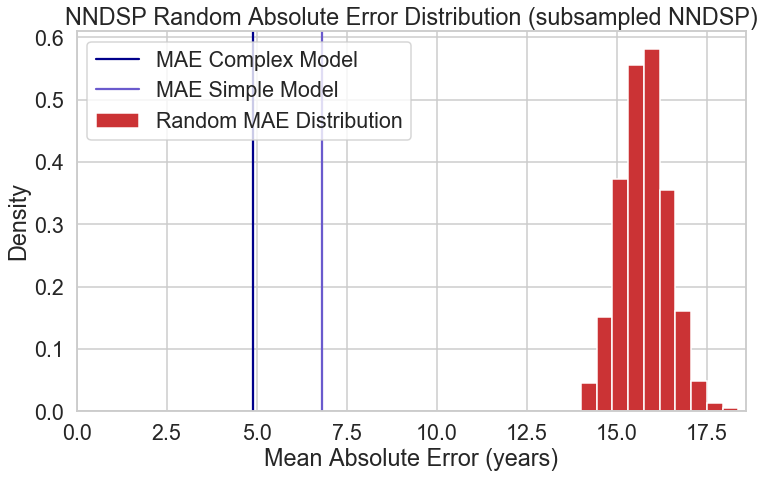

In [194]:
lines = {
    'MAE Complex Model' : scores_test.get_value(index='pred_age_test', col='mae'),
    'MAE Simple Model' : mean_absolute_error(y_train_atf, y_predicted_train_atf),
    #'MAE Simple Stacked Model' : mean_absolute_error(y_test_atf, y_predicted_test_ss),
}
plot_rand_histOne(arr_mae, lines, title='NNDSP Random Absolute Error Distribution (subsampled NNDSP)', set_context='talk',
               fig_tuple=(12, 7))

### Chance on HCP Data

In [125]:
# get all the subject ages
hcp_ages = pd.DataFrame([x for x in df_hcp.age])
# df of random age predictions
df_hcp_random_ages = pd.DataFrame([])
df_hcp_random_ages = df_hcp_random_ages.assign(subject = df_hcp.subject)

In [126]:
df_hcp_random_ages = random_its(1000, df_hcp_random_ages, [x for x in df_hcp.age])

In [127]:
arr_mae_hcp = get_arr_mae(df_hcp_random_ages, [x for x in df_hcp.age])

In [128]:
print(mean_absolute_error(hcp_ca.age, y_predicted_stack_hcp))
print(mean_absolute_error(hcp_atf.age, y_predicted_hcp_atf))

4.662525469559556
9.104123662926204


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

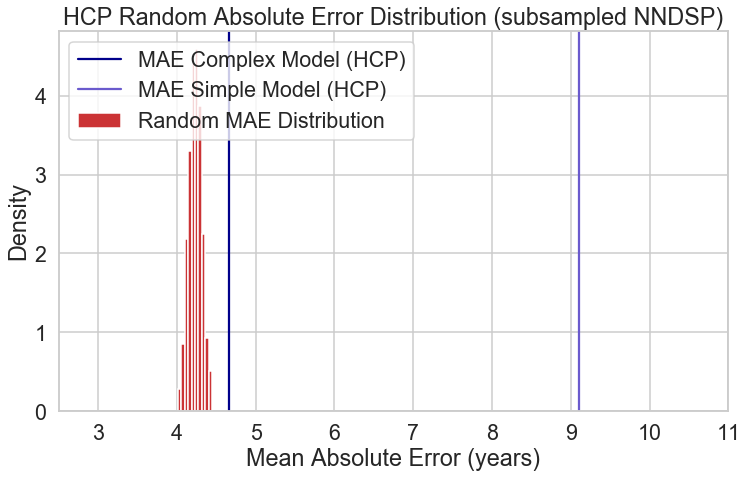

In [195]:
hcp_lines = {
    'MAE Complex Model (HCP)' : mean_absolute_error(hcp_ca.age, y_predicted_stack_hcp),
    'MAE Simple Model (HCP)' : mean_absolute_error(hcp_atf.age, y_predicted_hcp_atf)
}
plot_rand_histOne(arr_mae_hcp, hcp_lines, xlim_min = 2.5, x_max = 11, title='HCP Random Absolute Error Distribution (subsampled NNDSP)',
              set_context='talk', fig_tuple=(12, 7), legend=True)

### Chance on NKI Data

In [130]:
# get all the subject ages
df_nki_subject_ages = pd.DataFrame( [x for x in nki_atf.age])
# df of random age predictions
df_nki_random_ages = pd.DataFrame([])
df_nki_random_ages = df_nki_random_ages.assign(subject = nki_atf.subject)

In [131]:
df_nki_random_ages = random_its(1000, df_nki_random_ages,  [x for x in nki_atf.age])

In [132]:
arr_mae_nki = get_arr_mae(df_nki_random_ages,  [x for x in nki_atf.age])

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

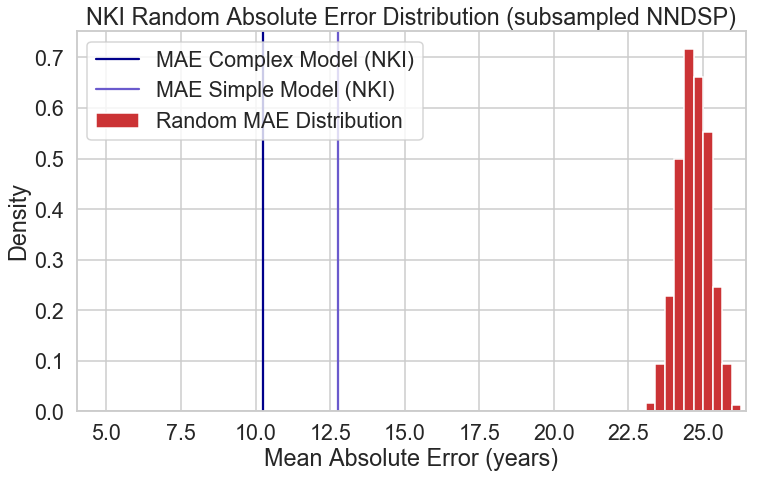

In [196]:
nki_lines = {
    'MAE Complex Model (NKI)' : mean_absolute_error(nki_ca.age, y_predicted_stack_nki),
    'MAE Simple Model (NKI)' : mean_absolute_error(nki_atf.age, y_predicted_nki_atf),
    #'MAE Simple Stacked Model (NKI)' : mean_absolute_error(df_nki_atf.age, y_predicted_nki_ss),
}
plot_rand_histOne(arr_mae_nki, nki_lines, xlim_min =4, title='NKI Random Absolute Error Distribution (subsampled NNDSP)',
              set_context='talk', fig_tuple=(12, 7))

## Hypothesis #2 

The model trained with many derived features will have better out of sample performance than a model trained with fewer, simpler features.

### Complex Model vs. Simple Model

In [134]:
temp_tr = y_train_atf.assign(y_pred = y_predicted_train_atf).sort_index()

statistic, pvalue, sum = wilcoxon_sum(np.subtract(temp_tr.y_pred.values, temp_tr.age_at_scan.values), 
                                      np.subtract(dd_train.pred_age_train, dd_train.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  5870.0 
 Pvalue:  0.39942358817298074 
 Correlation:  0.46147798742138363


<Figure size 432x288 with 0 Axes>

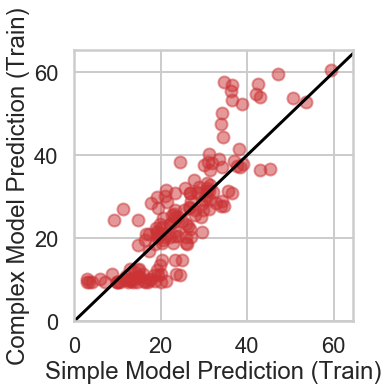

In [135]:
plot_simple_v_complex(temp_tr.y_pred.values, dd_train.pred_age_train, "(Train)")

In [136]:
temp_ts = y_test_atf.assign(y_pred = y_predicted_test_atf).sort_index()
statistic, pvalue, sum = wilcoxon_sum(np.subtract(temp_ts.y_pred.values, temp_ts.age_at_scan.values), 
                                      np.subtract(dd_test.pred_age_test, dd_test.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  6122.0 
 Pvalue:  0.5879835418555581 
 Correlation:  0.47531055900621116


<Figure size 432x288 with 0 Axes>

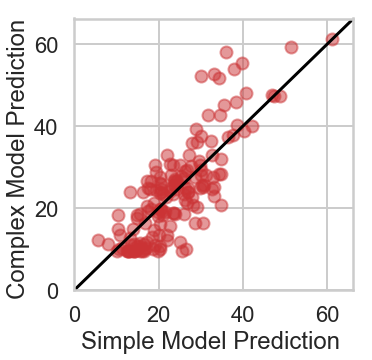

In [137]:
plot_simple_v_complex(temp_ts.y_pred, dd_test.pred_age_test, "", fig_tuple=(5, 5), fig_title='simple_graph.png')

In [197]:
def plot_ae_histOne(plot_list, title="", set_context='notebook', fig_tuple=(5,5), file_title=''):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    sns.set_context(set_context, font_scale=1.3)
    sns.set_style('whitegrid')
    sns.set_palette("Set1", 8, .75)
    
    fig,ax =plt.subplots(1, figsize=fig_tuple)
    
    for key, x in plot_list.items():
        sns.distplot(x, ax = ax, label = key)
    
    plt.legend(loc="best")
    plt.xlabel("Error (years)")
    plt.ylabel("Density")
    #plt.ylabel("Fraction")
    plt.title(title)
    plt.savefig('/data/NNDSP/anal/analysis_notebooks/SUB'+file_title)
    plt.show()

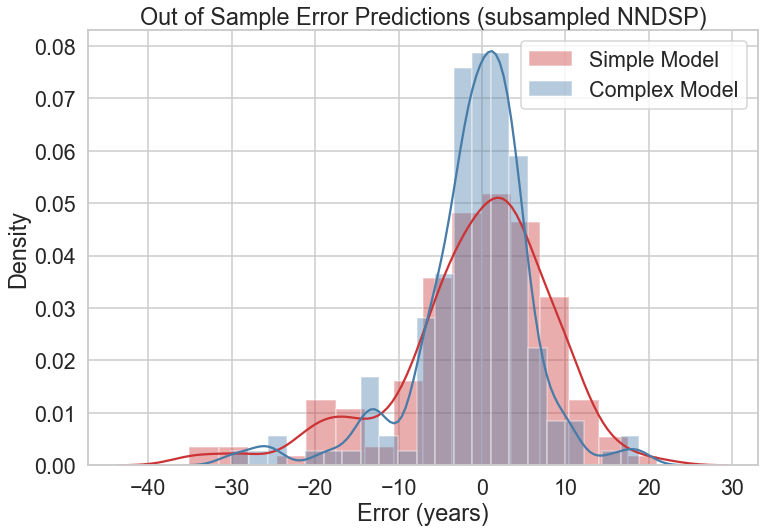

In [198]:
plot_list = {
    "Simple Model" : np.subtract(temp_ts.y_pred.values, temp_ts.age_at_scan.values), 
    "Complex Model" : np.subtract(dd_test.pred_age_test, dd_test.age_at_scan),
}
plot_ae_histOne(plot_list, title='Out of Sample Error Predictions (subsampled NNDSP)', set_context='talk',
            fig_tuple=(12, 8), file_title='simple_hist.png')

## Hypothesis #3

The model trained with many derived features will perform better than the model with fewer, simpler features when tested on data collected at different sites. 

### HCP Data

#### Complex Model vs Simple Model

In [144]:
def get_wil_help(df_atf, y_pred_atf, y_pred_stack, df_age, subj='subject'):
    df = pd.DataFrame([])
    df[subj] = df_atf[subj]
    df['atf_pred'] = y_pred_atf
    df['stack'] = y_pred_stack
    df = df.merge(df_age, on = subj)
    df['Atf_Err'] = np.subtract(df.atf_pred, df.age)
    df['Complx_Err'] = np.subtract(df['stack'], df.age)
    return df

In [145]:
df_hcp_pred_data = get_wil_help(hcp_atf, y_predicted_hcp_atf,
                                  y_predicted_stack_hcp, df_hcp, subj='subject')

In [146]:
statistic, pvalue, sum = wilcoxon_sum(df_hcp_pred_data.Atf_Err, df_hcp_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  47914.0 
 Pvalue:  1.3970927826837972e-86 
 Correlation:  0.11949820430965682


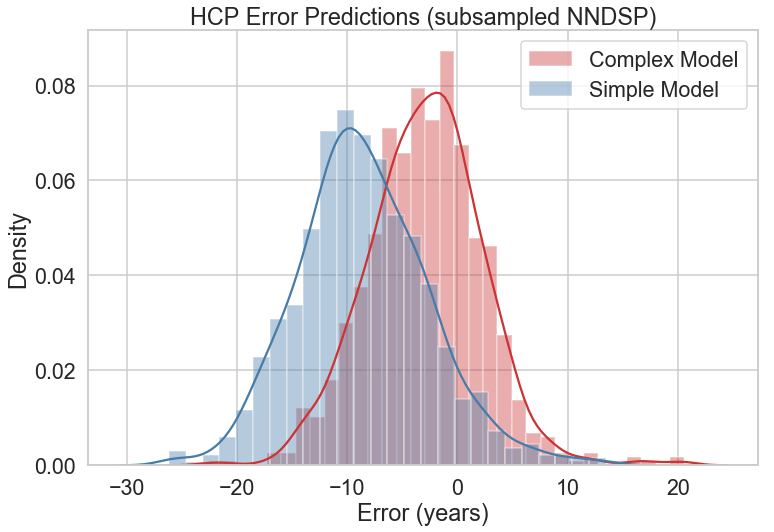

In [199]:
plot_list_hcp = {
    "Complex Model" : df_hcp_pred_data.Complx_Err,
    "Simple Model" : df_hcp_pred_data.Atf_Err
}
plot_ae_histOne(plot_list_hcp, title='HCP Error Predictions (subsampled NNDSP)', set_context='talk',
            fig_tuple=(12, 8), file_title='hcp_simple_hist.png')

### NKI Data

#### Complex Model vs Simple Model

In [149]:
def get_wil_help(df_atf, y_pred_atf, y_pred_stack, df_age, subj='Subject',):
    df = pd.DataFrame([])
    df[subj] = df_atf[subj]
    df['atf_pred'] = y_pred_atf
    df['stack'] = y_pred_stack
    df = df.merge(df_age, on = subj)
    df['Atf_Err'] = np.subtract(df.atf_pred, df.age)
    df['Complx_Err'] = np.subtract(df['stack'], df.age)
    return df

In [150]:
df_nki_pred_data = get_wil_help(nki_atf, y_predicted_nki_atf,y_predicted_stack_nki,
                                 df_nki, subj='subject')

In [151]:
statistic, pvalue, sum = wilcoxon_sum(df_nki_pred_data.Atf_Err, df_nki_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  193179.0 
 Pvalue:  0.5846472664689585 
 Correlation:  0.48941264098744414


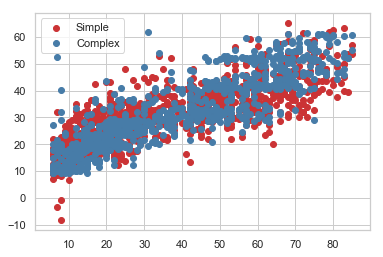

<Figure size 432x288 with 0 Axes>

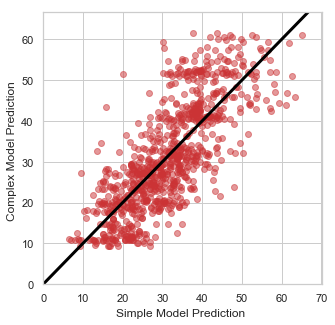

In [152]:
import seaborn as sns
sns.set_context('notebook')
plt.scatter(df_nki_pred_data.age, df_nki_pred_data.atf_pred, label = 'Simple')
plt.scatter(df_nki_pred_data.age, df_nki_pred_data['stack'], label ='Complex')
plt.legend(loc='best')
plt.show()
plot_simple_v_complex(df_nki_pred_data.atf_pred, df_nki_pred_data['stack'], title='',
                     fig_tuple=(5, 5), fig_title='nki_graph.png')

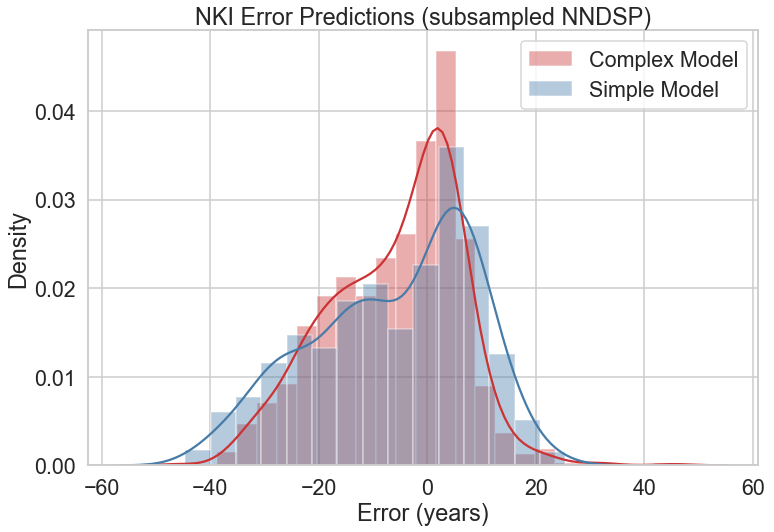

In [200]:
plot_list_nki = {
    "Complex Model" : df_nki_pred_data.Complx_Err,
    "Simple Model" : df_nki_pred_data.Atf_Err
}
plot_ae_histOne(plot_list_nki, title='NKI Error Predictions (subsampled NNDSP)', set_context='talk',
            fig_tuple=(12, 8), file_title='nki_simple_hist.png')

# Exploratory Analysis

In [271]:
def subsample_iterations(num_iter, 
                         df_data_ct, df_data_sv, df_data_ca, 
                         df_data_hcp_ct, df_data_hcp_sv, df_data_hcp_ca, 
                         df_data_nki_ct, df_data_nki_sv, df_data_nki_ca,
                         df_atf, df_hcp_atf, df_nki_atf):
    import pandas as pd
#     df_tt_split = pd.DataFrame(columns=['stack_ts', 'stack_hcp', 'stack_nki','simple_ts',
#                                     'simple_hcp','simple_nki', 'wstat_ts', 
#                                         'wpval_ts', 'wstat_hcp',
#                                         'wpval_hcp', 
#                                         'wstat_nki',
#                                         'wpval_nki',
#                                        'kstat_ts', 'kpval_ts',
#                                        'kstat_hcp', 'kpval_hcp',
#                                        'kstat_nki', 'kpval_nki'])

    wstat_ts = []
    wpval_ts = []
    wstat_hcp = []
    wpval_hcp = []
    wstat_nki = []
    wpval_nki = []
    kstat_ts = []
    kpval_ts = []
    kstat_hcp = []
    kpval_hcp = []
    kstat_nki = []
    kpval_nki = []
    
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error
    
    for i in range(num_iter):
        # for ct
        X_train_ct, X_test_ct, y_train_ct, y_test_ct, pipe_ct = train_test_pipeline(df_data_ct.iloc[:, :5124], 
                                                                                df_data_ct.age, 
                                                                                test_size = 0.5)
        pipe_ct.fit(X=X_train_ct, y=y_train_ct)
    
        # for sv
        X_train_sv, X_test_sv, y_train_sv, y_test_sv, pipe_sv = train_test_pipeline(df_data_sv.iloc[:, :66], 
                                                                                df_data_sv.age, 
                                                                                test_size = 0.5, 
                                                                                model='yes', model_train=X_train_ct,
                                                                                model_test=X_test_ct)
        pipe_sv.fit(X=X_train_sv, y= y_train_sv.as_matrix().ravel())
    
        # for ca
        X_train_ca, X_test_ca, y_train_ca, y_test_ca, pipe_ca = train_test_pipeline(df_data_ca.iloc[:, :5124], 
                                                                                df_data_ca.age, 
                                                                                test_size = 0.5,
                                                                                model='yes', model_train=X_train_ct,
                                                                                model_test=X_test_ct)
        pipe_ca.fit(X=X_train_ca, y= y_train_ca.as_matrix().ravel())
    
        # for complex stacked
        source_dict = {
            'aseg': get_stacked_ages(y_train_sv, pipe_sv.predict(X_train_sv), cross_val_predict(pipe_sv, X_train_sv, y_train_sv.as_matrix().ravel()),
                                       y_test_sv, pipe_sv.predict(X_test_sv)),
            'ct': get_stacked_ages(y_train_ct, pipe_ct.predict(X_train_ct), cross_val_predict(pipe_ct, X_train_ct, y_train_ct),
                                       y_test_ct, pipe_ct.predict(X_test_ct), first=True),
            'ca': get_stacked_ages(y_train_ca, pipe_ca.predict(X_train_ca), cross_val_predict(pipe_ca, X_train_ca, y_train_ca.as_matrix().ravel()),
                                       y_test_ca, pipe_ca.predict(X_test_ca))
                }
        source_selection_dict = {'fs': ['aseg', 'ct', 'ca'],}
        scores_test, dd_train, dd_test, pipe_stack = stacking(source_dict, source_selection_dict, 'age', show=False)
    
        # get the predictions after fitting
        
        #df_tt_split.set_value(i, 'stack_ts', mean_absolute_error(dd_test.age_at_scan, dd_test.pred_age_test))
    
        df_stack_hcp = pd.DataFrame([])
        df_stack_hcp['aseg'] = pipe_sv.predict(df_data_hcp_sv.iloc[:,:66])
        df_stack_hcp['ct'] = pipe_ct.predict(df_data_hcp_ct.iloc[:,:5124])
        df_stack_hcp['ca'] = pipe_ca.predict(df_data_hcp_ca.iloc[:,:5124])
        df_stack_hcp['Subject'] = df_data_hcp_ct.subject.values

        y_predicted_stack_hcp = pipe_stack.predict(df_stack_hcp.iloc[:,:3])    
       
        #df_tt_split.set_value(i, 'stack_hcp', mean_absolute_error(df_data_hcp_ca.iloc[:,5125], y_predicted_stack_hcp))
    
        # for nki
        df_stack_nki = pd.DataFrame([])
        df_stack_nki['aseg'] = pipe_sv.predict(df_data_nki_sv.iloc[:,:66])
        df_stack_nki['ct'] = pipe_ct.predict(df_data_nki_ct.iloc[:,:5124])
        df_stack_nki['ca'] = pipe_ca.predict(df_data_nki_ca.iloc[:,:5124])
        df_stack_nki['Subject'] = df_data_nki_ct.subject.values

        y_predicted_stack_nki = pipe_stack.predict(df_stack_nki.iloc[:,:3])
        
        #df_tt_split.set_value(i, 'stack_nki', mean_absolute_error(df_data_nki_ca.iloc[:,5125], y_predicted_stack_nki))
    
        # for simple model
        X_train_atf, X_test_atf, y_train_atf, y_test_atf, pipe_atf =  train_test_pipeline(df_atf.iloc[:, 3:], 
                                                                                  df_atf.age, 
                                                                                  test_size = 0.5,
                                                                                  model='yes', 
                                                                                  model_train=X_train_ct, 
                                                                                  model_test=X_test_ct)
        pipe_atf.fit(X=X_train_atf, y=y_train_atf.as_matrix().ravel())
    
        # get prediction after fitting
        y_predicted_test_atf = pipe_atf.predict(X_test_atf)
        y_predicted_hcp_atf = pipe_atf.predict(df_hcp_atf.iloc[:, 2:])
        y_predicted_nki_atf = pipe_atf.predict(df_nki_atf.iloc[:, 5:])
    
        # add mean absolute error
        #df_tt_split.set_value(i, 'simple_ts', mean_absolute_error(y_test_atf, y_predicted_test_atf))
        #df_tt_split.set_value(i, 'simple_hcp', mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf))
        #df_tt_split.set_value(i, 'simple_nki', mean_absolute_error(df_nki_atf.age, y_predicted_nki_atf))
    
        temp_ts = y_test_atf.assign(y_pred = y_predicted_test_atf).sort_index()
        statistic, ts_pvalue, sum = wilcoxon_sum(np.subtract(temp_ts.y_pred.values, temp_ts.age_at_scan.values), 
                                      np.subtract(dd_test.pred_age_test, dd_test.age_at_scan))
        wstat_ts.append(statistic)
        wpval_ts.append(ts_pvalue)
#         df_tt_split.set_value(i, 'wstat_ts', statistic)
#         df_tt_split.set_value(i, 'wpval_ts', ts_pvalue)
    
        statistic, hcp_pvalue, sum = wilcoxon_sum(np.subtract(y_predicted_hcp_atf, df_hcp_atf.age),
                                             np.subtract(y_predicted_stack_hcp, df_data_hcp_ca.age))
#         df_tt_split.set_value(i, 'wstat_hcp', statistic)
#         df_tt_split.set_value(i, 'wpval_hcp', hcp_pvalue)
        wstat_hcp.append(statistic)
        wpval_hcp.append(hcp_pvalue)
    
        statistic, nki_pvalue, sum = wilcoxon_sum(np.subtract(y_predicted_nki_atf, df_nki_atf.age),
                                             np.subtract(y_predicted_stack_nki, df_data_nki_ca.age))
#         df_tt_split.set_value(i, 'wstat_nki', statistic)
#         df_tt_split.set_value(i, 'wpval_nki', nki_pvalue)
        
        wstat_nki.append(statistic)
        wpval_nki.append(nki_pvalue)
        
        from scipy import stats
    
        statistic, ts_pvalue = stats.ks_2samp(np.subtract(temp_ts.y_pred.values, temp_ts.age_at_scan.values), 
                                      np.subtract(dd_test.pred_age_test, dd_test.age_at_scan))
#         df_tt_split.set_value(i, 'kstat_ts', statistic)
#         df_tt_split.set_value(i, 'kpval_ts', ts_pvalue)
        kstat_ts.append(statistic)
        kpval_ts.append(ts_pvalue)
    
        statistic, hcp_pvalue = stats.ks_2samp(np.subtract(y_predicted_hcp_atf, df_hcp_atf.age),
                                             np.subtract(y_predicted_stack_hcp, df_data_hcp_ca.age))
#         df_tt_split.set_value(i, 'kstat_hcp', statistic)
#         df_tt_split.set_value(i, 'kpval_hcp', hcp_pvalue)
        kstat_hcp.append(statistic)
        kpval_hcp.append(hcp_pvalue)
    
        statistic, nki_pvalue = stats.ks_2samp(np.subtract(y_predicted_nki_atf, df_nki_atf.age),
                                             np.subtract(y_predicted_stack_nki, df_data_nki_ca.age))
#         df_tt_split.set_value(i, 'kstat_nki', statistic)
#         df_tt_split.set_value(i, 'kpval_nki', nki_pvalue)
        
        kstat_nki.append(statistic)
        kpval_nki.append(nki_pvalue)
        
        print(i)
        
        with open('/data/NNDSP/anal/analysis_notebooks/other_files/iter_log.txt','a') as f:
            f.write("Iteration %d\n" % (i))
        
        #print(df_tt_split.iloc[i, :])
    
        df_tt_split = pd.DataFrame({'wstat_ts' : wstat_ts, 'wpval_ts' : wpval_ts,
                               'wstat_hcp' : wstat_hcp, 'wpval_hcp' : wpval_hcp, 
                               'wstat_nki': wstat_nki, 'wpval_nki': wpval_nki,
                               'kstat_ts' : kstat_ts, 'kpval_ts' : kpval_ts,
                               'kstat_hcp' : kstat_hcp, 'kpval_hcp' : kpval_hcp, 
                               'kstat_nki': kstat_nki, 'kpval_nki': kpval_nki})
    f.close()    
    return df_tt_split

## Train Test Split

In [239]:
nki_atf['random'] = [0 for x in range(0, len(nki_atf))]

In [241]:
nki_atf = nki_atf[['subject', 'age', 'random', 'sex', 'handedness', 'Intra_Cran_Vol',
       'WM_Frac', 'GM_Frac', 'CSF_Frac' ]]

In [262]:
hcp_atf = hcp_atf.rename(columns={'Subject':'subject'})
hcp_ca = hcp_ca.rename(columns={'Subject':'subject'})
hcp_ct = hcp_ct.rename(columns={'Subject':'subject'})
hcp_sv = hcp_sv.rename(columns={'Subject':'Subject'})

nki_atf = nki_atf.rename(columns={'participant_id': 'subject'})
nki_ca = nki_ca.rename(columns={'participant_id': 'subject'})
nki_ct = nki_ct.rename(columns={'participant_id': 'subject'})
nki_sv = nki_sv.rename(columns={'participant_id': 'subject'})

In [ ]:
test = subsample_iterations(30000, nndsp_ct, nndsp_sv, nndsp_ca, 
                       hcp_ct, hcp_sv, hcp_ca, 
                       nki_ct, nki_sv, nki_ca,
                       nndsp_atf, hcp_atf[['subject', 'age', 'Intra_Cran_Vol', 'WM_Frac', 'GM_Frac', 'CSF_Frac']], 
                       nki_atf)